#
<div align=left>
    <img src="https://unifor.br/o/unifor-theme/images/unifor-logo-horizontal.svg" width=120 height=120>
</div>
<font size=5 color=k><strong>Aluno:</strong> Equipe 4

<strong>Disciplina:</strong> Ciência de dados

<strong>Professor:</strong> Rilder Pires 

<strong>Assunto:</strong> Redes Convolucionais

<strong>Título:</strong> Previsão da idade óssea por imgs de raio-x

## 
<font size=5 color=blue> 1 - Observações

Modelo base de treinamento:
ResNet50 V2

Treinamos a partir dos pesos iniciais já definidos da imagenet.
Ao fim das camadas de convolução foram adicionadas:


1 camada de pooling,

1 camada densa de 1024 neurônios(relu)

1 camada densa de 1 neurônio já que nosso dataset é um problema de regressao


OBS:
nesse treinamento foi levado em consideracao apenas o genero masculino

## 
<font size=5 color=blue> 2 - Bibliotecas e configuração de GPU

In [1]:
import pandas as pd
import GPUtil
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from processamento_de_dados import criar_dataset, filtrar_por_genero
from metricas_heitor import r2
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
#from tensorflow.keras.applications import ResNet50V2


import math

np.random.seed(123)
random.seed(123)
tf.random.set_seed(123)

In [2]:
tf_gpu = tf.config.experimental.list_physical_devices('GPU')
nome_gpu = GPUtil.getGPUs()

if tf_gpu:
    try:
        tf.config.experimental.set_memory_growth(tf_gpu[0], True)
        print("gpu:", nome_gpu[0].name)
    except RuntimeError as e:
        print(e)


Physical devices cannot be modified after being initialized


## 
<font size=5 color=blue> 3 - Criação dos datasets de treino, validação e teste

In [3]:
# importando as labels e definindo diretório das imagens
csv_treino = pd.read_csv('../train.csv')
csv_validacao = pd.read_csv('../Validation Dataset.csv')
#csv_teste = pd.read_csv('../test_dataset.csv')
csv_teste = pd.DataFrame()
dir_imagens = '../imagens'


# 0 - todos
# 1 - masculino
# 2 - feminino
genero=0

csv_treino = filtrar_por_genero(csv_treino, genero)
csv_validacao = filtrar_por_genero(csv_validacao, genero)
csv_teste = filtrar_por_genero(csv_teste, genero)

In [4]:
print(len(csv_treino ))
print(len(csv_validacao))
print(len(csv_teste ))

12610
1425
0


### 
<font size=5 color=green> 3.1 - misturando um pouco os dados

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
# Número de amostras a serem trocadas
num_teste_para_treino = 0
num_teste_para_validacao = 0

num_validacao_para_teste = 0

num_treino_para_teste = 1200
num_treino_para_validacao = 0


# Dividindo o DataFrame de teste para mover para treino
csv_teste_para_treino = csv_teste.sample(num_teste_para_treino, random_state=42)
csv_teste = csv_teste.drop(csv_teste_para_treino.index)

# Dividindo o DataFrame de validação para mover para teste
csv_validacao_para_teste = csv_validacao.sample(num_validacao_para_teste, random_state=42)
csv_validacao = csv_validacao.drop(csv_validacao_para_teste.index)

# Dividindo o DataFrame de teste para mover para validacao
csv_teste_para_validacao = csv_teste.sample(num_teste_para_validacao, random_state=42)
csv_teste = csv_teste.drop(csv_teste_para_validacao.index)

# Dividindo o DataFrame de treino para mover para validacao
csv_treino_para_validacao = csv_treino.sample(num_treino_para_validacao, random_state=42)
csv_treino = csv_treino.drop(csv_treino_para_validacao.index)

# Dividindo o DataFrame de treino para mover para teste
csv_treino_para_teste = csv_treino.sample(num_treino_para_teste, random_state=42)
csv_treino = csv_treino.drop(csv_treino_para_teste.index)


# Adicionando dados de teste ao conjunto de treinamento
csv_treino = pd.concat([csv_treino, csv_teste_para_treino])

# Adicionando dados de validação e de treino ao conjunto de teste
csv_teste = pd.concat([csv_teste, csv_validacao_para_teste, csv_treino_para_teste])

# Adicionando dados de validação e de treino ao conjunto de teste
csv_validacao = pd.concat([csv_validacao, csv_teste_para_validacao, csv_treino_para_validacao])


In [7]:
print(len(csv_treino ))
print(len(csv_validacao))
print(len(csv_teste ))

11410
1425
1200


### 
<font size=5 color=green> 3.2 - criando os datasets

In [8]:
# parametros
img_tamanho = (299, 299) 
batch_size = 64
epocas = 100
lr = 0.001
otimizador = Adam(learning_rate=lr)
erro = 'mae'
funcao_atv = 'relu'
passo_para_salvar_pesos = 2

# criando os dataset
dataset_validacao = criar_dataset(
    dataframe=csv_validacao,
    diretorio=dir_imagens,
    img_tamanho=img_tamanho,
    batch_size=batch_size,
    data_augmentation=False,
    shuffle=False,
    png=True)

dataset_teste = criar_dataset(
    dataframe=csv_teste,
    diretorio=dir_imagens,
    img_tamanho=img_tamanho,
    batch_size=batch_size,
    data_augmentation=False,
    shuffle=False,
    png=False)

dataset_treino = criar_dataset(
    dataframe=csv_treino,
    diretorio=dir_imagens,
    img_tamanho=img_tamanho,
    batch_size=batch_size,
    data_augmentation=False,
    shuffle=True,
    png=True)

## 
<font size=5 color=blue> 4 - Definição do modelo e treinamento

In [9]:
dir_pesos_salvos = "InceptionResNetV2_epoca_{epoch:02d}.hdf5"
# callbacks
checkpoint = ModelCheckpoint(
    filepath=dir_pesos_salvos,
    save_weights_only=True,
    save_best_only=False,
    verbose=1,
    period=passo_para_salvar_pesos)

checkpoint_best = ModelCheckpoint(
    filepath="melhor_modelo.hdf5",
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1)

early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=20,
    verbose=1)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.000001,
    verbose=1)


In [10]:
# modelo 2 = ResNet50V2
modelo_base = InceptionResNetV2(weights='imagenet', include_top=False,)

# aqui quando sai das camadas convolução eu adicionei uma camada de pooling, 
# depois uma densa com 1024 neuronios com a relu
# e depois outra densa com 1 só neuronio também relu.
# 1 só neuronio pq é uma tarefa de regressão e relu pq nosso dado é continuo e não negativo
x = modelo_base.output
y = GlobalAveragePooling2D()(x)
z = Dense(1024, activation='relu')(y)

camada_de_previsao = Dense(1, activation='relu')(z)

model = Model(inputs=modelo_base.input, outputs=camada_de_previsao)

model.compile(optimizer=otimizador, loss=erro)


In [11]:
# treinamento
model.fit(dataset_treino, 
          validation_data=dataset_validacao,
          steps_per_epoch=len(csv_treino) // batch_size, 
          validation_steps=len(csv_validacao) // batch_size,
          epochs=epocas,
          callbacks=[checkpoint, reduce_lr])

Epoch 1/100
178/178 [==============================] - 130s 635ms/step - loss: 18.2338 - val_loss: 23.5663 - lr: 0.0010
Epoch 2/100
178/178 [==============================] - ETA: 0s - loss: 12.2544
Epoch 2: saving model to InceptionResNetV2_epoca_02.hdf5
178/178 [==============================] - 112s 627ms/step - loss: 12.2544 - val_loss: 13.5183 - lr: 0.0010
Epoch 3/100
178/178 [==============================] - 115s 644ms/step - loss: 11.3748 - val_loss: 10.9223 - lr: 0.0010
Epoch 4/100
178/178 [==============================] - ETA: 0s - loss: 10.4762
Epoch 4: saving model to InceptionResNetV2_epoca_04.hdf5
178/178 [==============================] - 109s 610ms/step - loss: 10.4762 - val_loss: 13.4522 - lr: 0.0010
Epoch 5/100
178/178 [==============================] - 101s 568ms/step - loss: 9.7285 - val_loss: 9.7584 - lr: 0.0010
Epoch 6/100
178/178 [==============================] - ETA: 0s - loss: 9.4041
Epoch 6: saving model to InceptionResNetV2_epoca_06.hdf5
178/178 [==========

## 
<font size=5 color=blue> 5 - Testando o modelo e salvando predições para análises futuras

In [12]:
# configuração do modelo
model.compile(optimizer=otimizador, loss='mae', metrics=[r2])

epocas = 100

# Loop para avaliação do modelo e geração dos CSVs
for epoca in range(passo_para_salvar_pesos, epocas + 1, passo_para_salvar_pesos):
    peso_arquivo = f"InceptionResNetV2_epoca_{epoca:02d}.hdf5"
    model.load_weights(peso_arquivo)
    
    # Avalia o modelo
    resultado_teste = model.evaluate(dataset_teste, steps=math.ceil(len(csv_teste) // batch_size))
    print(f"epoca {epoca} - mae: {resultado_teste[0]}, r2: {resultado_teste[1]}")

    # Geração das predições
    num_steps = math.ceil(len(csv_teste) / batch_size)
    predicoes = model.predict(dataset_teste, steps=num_steps)
    labels_teste = csv_teste['boneage'].values

    # Preparação e salvamento do CSV
    resultados_df = pd.DataFrame({
        'id': csv_teste['id'].values,
        'real': labels_teste,
        'predito': predicoes.flatten()
    })
    
    resultados_df.to_csv(f'InceptionResNetV2_resultados_epoca_{epoca}.csv', index=False)



18/18 [==============================] - 6s 156ms/step - loss: 13.5720 - r2: 0.8205
epoca 2 - mae: 13.571982383728027, r2: 0.8204657435417175
18/18 [==============================] - 3s 156ms/step - loss: 13.8043 - r2: 0.8099
epoca 4 - mae: 13.804283142089844, r2: 0.8099141716957092
18/18 [==============================] - 3s 155ms/step - loss: 13.5332 - r2: 0.8288
epoca 6 - mae: 13.53316593170166, r2: 0.8287543654441833
18/18 [==============================] - 3s 160ms/step - loss: 10.6765 - r2: 0.8827
epoca 8 - mae: 10.676535606384277, r2: 0.8826557993888855
18/18 [==============================] - 3s 155ms/step - loss: 10.5012 - r2: 0.8817
epoca 10 - mae: 10.501182556152344, r2: 0.8816596865653992
18/18 [==============================] - 3s 160ms/step - loss: 10.6982 - r2: 0.8817
epoca 12 - mae: 10.698221206665039, r2: 0.8816542029380798
18/18 [==============================] - 3s 158ms/step - loss: 9.8535 - r2: 0.8964
epoca 14 - mae: 9.853504180908203, r2: 0.8963838219642639
18/18 

## 
<font size=5 color=blue> 6 - Análises e gráficos

In [2]:
import pandas as pd
epoca = 82

csv_da_epoca_escolhida = f'InceptionResNetV2_resultados_epoca_{epoca}.csv'
dados = pd.read_csv(csv_da_epoca_escolhida)

dados['erro_absoluto'] = abs(dados['real'] - dados['predito'])
dados['faixa_Etaria'] = pd.cut(dados['real'], bins=[0, 30, 60, 90, 120, 150, 180, 240])
erro_por_faixa = dados.groupby('faixa_Etaria')['erro_absoluto'].mean()
contagem_por_faixa = dados['faixa_Etaria'].value_counts().reindex(erro_por_faixa.index)
display(erro_por_faixa)
display(contagem_por_faixa)
display(dados)


C:\Users\Pichau\AppData\Local\Temp\ipykernel_25308\1352257858.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  erro_por_faixa = dados.groupby('faixa_Etaria')['erro_absoluto'].mean()


faixa_Etaria
(0, 30]        6.306084
(30, 60]       9.494440
(60, 90]       8.675208
(90, 120]     10.988979
(120, 150]     8.791998
(150, 180]     8.475590
(180, 240]     9.974392
Name: erro_absoluto, dtype: float64

faixa_Etaria
(0, 30]        20
(30, 60]       78
(60, 90]      143
(90, 120]     292
(120, 150]    292
(150, 180]    303
(180, 240]     72
Name: count, dtype: int64

,id,real,predito,erro_absoluto,faixa_Etaria
0,10614.png,120,129.728030,9.728030,"(90, 120]"
1,14254.png,132,119.590580,12.409420,"(120, 150]"
2,3546.png,180,173.939560,6.060440,"(150, 180]"
3,10431.png,156,160.513810,4.513810,"(150, 180]"
4,11987.png,72,74.090904,2.090904,"(60, 90]"
...,...,...,...,...,...
1195,4965.png,156,162.900450,6.900450,"(150, 180]"
1196,3027.png,120,127.695280,7.695280,"(90, 120]"
1197,1762.png,109,118.748955,9.748955,"(90, 120]"
1198,4749.png,144,146.284880,2.284880,"(120, 150]"


c:\Users\Pichau\anaconda3\envs\tfgpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Pichau\anaconda3\envs\tfgpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


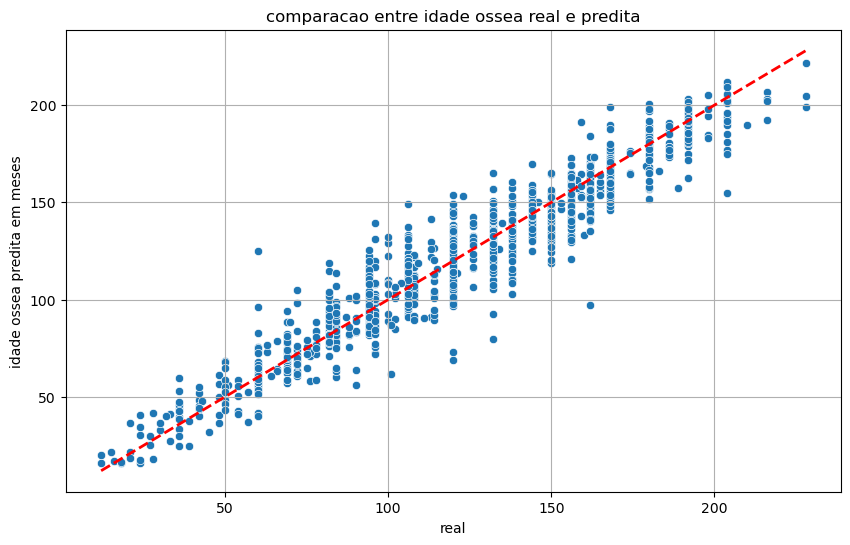

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='real', y='predito', data=dados)

plt.plot([dados['real'].min(), dados['real'].max()], [dados['real'].min(), dados['real'].max()], color='red', lw=2, linestyle='--')

plt.title('comparacao entre idade ossea real e predita')
plt.ylabel('idade ossea predita em meses')
plt.grid(True)
plt.show()

c:\Users\Pichau\anaconda3\envs\tfgpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Pichau\anaconda3\envs\tfgpu\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


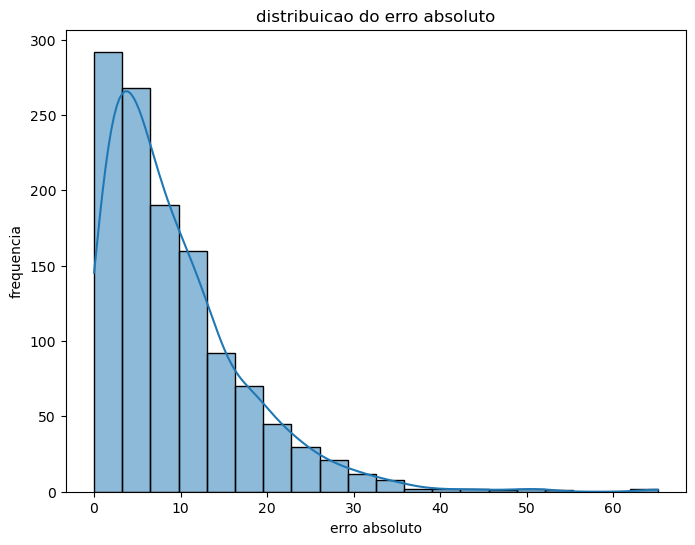

In [15]:
plt.figure(figsize=(8, 6))
sns.histplot(dados['erro_absoluto'], bins=20, kde=True)
plt.title('distribuicao do erro absoluto')
plt.xlabel('erro absoluto')
plt.ylabel('frequencia')
plt.show()
